#### In this section, we will build a text classication using supervised learning technique which can can predict the rating based on the reviews.

### Packages

In [1]:
import kaggle
import pandas as pd
import matplotlib.pyplot as plt 
import pyarrow
import fastparquet
import numpy as np
import os
from collections import Counter, defaultdict
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from wordcloud import WordCloud 
#kaggle.api.authenticate()
import nltk
from string import punctuation
import textacy.preprocessing as tprep
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## Step 1: Data Preparation


####    Loading Dataset for Modeling

In [2]:
new_df=pd.read_parquet('prepared_text.parquet.gzip', engine='pyarrow')
new_df.head(3)

,Rating,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities,tokens,token_count,new_reviews
0,5,"[feel, lucky, find, use, phone, use, hard, pho...","[feel, lucky, find, hard, upgrade, sell, like,...","[phone, phone, line, son, year, thank, seller,...","[phone_line, thank_seller]","[hard_phone, hard_phone_line, old_one, recomme...",[],"[feel, lucky, found, used, phone, us, used, ha...",38,feel lucky found used phone us used hard phone...
1,4,"[nice, phone, nice, grade, pantach, revue, cle...","[nice, nice, clean, easy, android, fantastic, ...","[phone, grade, pantach, revue, set, set, phone...",[grade_pantach],"[nice_phone, nice_grade, nice_grade_pantach, c...",[android/GPE],"[nice, phone, nice, grade, pantach, revue, cle...",24,nice phone nice grade pantach revue clean set ...
2,5,[pleased],[pleased],[],[],[],[],[pleased],1,pleased


#### Removing unecessary columns prior to modeling 

In [3]:

new_df =new_df[[
    'Rating','new_reviews','tokens'
]]

In [4]:
new_df.info()
print('\n')
print(new_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405669 entries, 0 to 405668
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Rating       405669 non-null  int64 
 1   new_reviews  405669 non-null  object
 2   tokens       405669 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


(405669, 3)


#### Checking for Class Imbalance

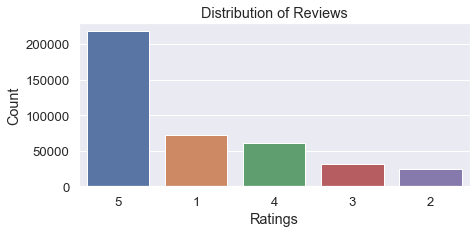

In [5]:

plt.figure(figsize=(7,3))
sns.set(font_scale = 1.2)
sns.countplot(x="Rating", data=new_df,
order = new_df['Rating'].value_counts().index)
plt.title("Distribution of Reviews")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

#### Undersampling Majority class 

In [6]:
# undersampling 5-star reviews and oversampling other reviews 
five_stars = new_df[new_df['Rating'] == 5].sample(n=70000)
non_five = new_df[new_df['Rating'] != 5 ]
df_bal = pd.concat([five_stars,non_five],axis=0)

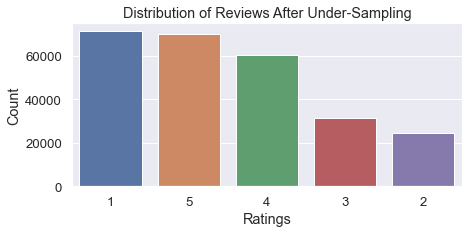

In [7]:

plt.figure(figsize=(7,3))
sns.set(font_scale = 1.2)
sns.countplot(x="Rating", data=df_bal,
order = df_bal['Rating'].value_counts().index)
plt.title("Distribution of Reviews After Under-Sampling")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

## Step 2: Train-Test Split on Balanced Dataset

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_bal['new_reviews'],
                                                       df_bal['Rating'],
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=df_bal['Rating'])
print ('Size of Training Data ', X_train.shape[0]) 
print ('Size of Test Data ', X_test.shape[0])
print ('Distribution of classes in Training Data :')
#print ('Positive Sentiment ', str(sum(Y_train == 1)/ len(Y_train) * 100.0))
# print ('Negative Sentiment ', str(sum(Y_train == 0)/ len(Y_train) * 100.0))
#print ('Distribution of classes in Testing Data :')
#print ('Positive Sentiment ', str(sum(Y_test == 1)/ len(Y_test) * 100.0)) 
#print ('Negative Sentiment ', str(sum(Y_test == 0)/ len(Y_test) * 100.0))

Size of Training Data  205997
Size of Test Data  51500
Distribution of classes in Training Data :


## Step 3: Text Vectorization

##### 	Using TF-IDF vectorization to create the vectorized representation:

In [10]:
def identity_tokenizer(text):
  return text


tfidf = TfidfVectorizer(tokenizer=identity_tokenizer,min_df = 10,ngram_range=(1,2),lowercase=False)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

## Step 4: Training the Machine Learning Models

#### Model : Linear SVC

In [11]:

model_svc = LinearSVC(random_state=0, tol=1e-5)
model_svc.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

 ## Step 5 : Model Evaluation

In [12]:
Y_pred_svc = model_svc.predict(X_test_tf)
print ('Accuracy Score  - ', accuracy_score(Y_test, Y_pred_svc)) 
#print ('ROC-AUC Score - ', roc_auc_score(Y_test, Y_pred_svc))
print(classification_report(Y_test, Y_pred_svc))

Accuracy Score  -  0.5506407766990291
              precision    recall  f1-score   support

           1       0.57      0.87      0.69     14275
           2       0.38      0.02      0.03      4907
           3       0.40      0.08      0.13      6277
           4       0.45      0.44      0.44     12041
           5       0.62      0.72      0.67     14000

    accuracy                           0.55     51500
   macro avg       0.48      0.42      0.39     51500
weighted avg       0.51      0.55      0.49     51500



### Baseline Model Evaluation

In [13]:
clf_baseline = DummyClassifier(strategy='stratified')
clf_baseline.fit(X_train, Y_train)
Y_pred_baseline = clf_baseline.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))


Accuracy Score -  0.23135922330097086


### Performing Hyperparameter Tuning with Grid Search

In [14]:
training_pipeline = Pipeline(
        steps=[('tfidf', TfidfVectorizer(stop_words="english")),
                ('model', LinearSVC(random_state=42, tol=1e-5))])
grid_param = [{
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__penalty': ['l2'],
        'model__loss': ['hinge'],
        'model__max_iter': [10000]
},{
'tfidf__min_df': [5, 10], 'tfidf__ngram_range': [(1, 3), (1, 6)], 'model__C': [1, 10],
'model__tol': [1e-2, 1e-3]
}]
gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                       param_grid=grid_param,
                                       cv=5)
gridSearchProcessor.fit(df_bal['new_reviews'], df_bal['Rating'])
best_params = gridSearchProcessor.best_params_

print("Best alpha parameter identified by grid search ", best_params)
best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)                

Best alpha parameter identified by grid search  {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 6)}
Best result identified by grid search  0.5797621233101519


In [15]:
gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)
gridsearch_results[['rank_test_score', 'mean_test_score',
                        'params']].sort_values(by=['rank_test_score'])[:5]

,rank_test_score,mean_test_score,params
1,1,0.579762,"{'model__loss': 'hinge', 'model__max_iter': 10..."
0,2,0.577976,"{'model__loss': 'hinge', 'model__max_iter': 10..."
5,3,0.576752,"{'model__C': 1, 'model__tol': 0.01, 'tfidf__mi..."
9,4,0.576737,"{'model__C': 1, 'model__tol': 0.001, 'tfidf__m..."
8,5,0.576139,"{'model__C': 1, 'model__tol': 0.001, 'tfidf__m..."


In [20]:
best_chosen_model=gridSearchProcessor.best_estimator_

#### Model Evaluation After Hyper-parameter Tuning

In [22]:

Y_pred_bestmodel = best_chosen_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred_bestmodel))
print(classification_report(Y_test, Y_pred_bestmodel))

Accuracy Score -  0.8856116504854369
              precision    recall  f1-score   support

           1       0.90      0.98      0.94     14275
           2       0.98      0.81      0.89      4907
           3       0.96      0.82      0.88      6277
           4       0.83      0.85      0.84     12041
           5       0.86      0.88      0.87     14000

    accuracy                           0.89     51500
   macro avg       0.91      0.87      0.88     51500
weighted avg       0.89      0.89      0.89     51500

